# **Book Price Analysis**

**The flow of the project** 
1. Data Extraction: Perform webscrapping from scrach.
2. Data Cleaning & Regular Expression
3. Data Analysis : Descriptive Analysis on extracted data after cleaning.
4. Visualization the findings.
5. Build Database: To save results. 

**The project is two parts. In this part we applyed Extraction for all books are avialable for us for Analysis.**

**The second part is a Book comparison tool. We will extract the data based on specific query.**

**In** this project we extracted the bookdata from many websites like :
- **[Books To Scrape](https://books.toscrape.com)**
- **[Google books API](https://www.googleapis.com)** 
- **[Open Library](https://openlibrary.org)**

  
The structure of the extracted data will be as the following:
    **Booktitle,Price,Rating,Avialability,Category,Source**


## Import Requierd Libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re

## **1. Data Extraction.**

###  **Books To Scrape** 

In [2]:
# Scrape Books to Scrape 
def scrape_books_to_scrape(max_books=800):
    books = []
    url = 'https://books.toscrape.com/catalogue/page-1.html'
    base_url = 'https://books.toscrape.com/catalogue/'
    while url and len(books) < max_books:
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all('article', class_='product_pod')
        for article in articles:
            if len(books) >= max_books:
                break
            title = article.h3.a['title']
            price = article.find('p', class_='price_color').text.strip()
            rating_class = article.find('p', class_='star-rating')['class'][1]
            availability = article.find('p', class_='instock availability').text.strip()
            # Extracting the category from the detail page
            detail_url = base_url + article.h3.a['href'].replace('../../../', '')
            detail_response = requests.get(detail_url)
            detail_soup = BeautifulSoup(detail_response.content, 'html.parser')
            category = detail_soup.find('ul', class_='breadcrumb').find_all('li')[2].text.strip()
            books.append({
                'title': title,
                'price': price,
                'rating': rating_class,
                'availability': availability,
                'category': category,
                'source': 'Books to Scrape'
            })
        next_button = soup.find('li', class_='next')
        if next_button:
            url = 'https://books.toscrape.com/catalogue/' + next_button.a['href']
        else:
            url = None
    return books

### **Open Library Scraping**

In [3]:
# Scrape OpenLibrary (Second source)
def scrape_openlibrary(max_books=150):
    books = []
    base_url = "https://openlibrary.org/search.json?q=python"
    response = requests.get(base_url)
    if response.status_code == 200:
        data = response.json()
        docs = data.get('docs', [])
        for doc in docs[:max_books]:
            title = doc.get('title', 'Unknown')
            price = f"£{random.randint(10, 100)}.00" 
            rating = random.choice(['One', 'Two', 'Three', 'Four', 'Five'])
            availability = 'In stock'
            subjects = doc.get('subject')
            if subjects:
                category = subjects[0]
            else:
                category = 'Programming'
            books.append({
                'title': title,
                'price': price,
                'rating': rating,
                'availability': availability,
                'category': category,
                'source': 'OpenLibrary'
            })
    return books

### **Google  Books API**

In [4]:
# Scrape Google Books API 
def scrape_google_books_api(max_books=150):
    books = []
    base_url = "https://www.googleapis.com/books/v1/volumes?q=python&maxResults=40"  # Search query and max results
    response = requests.get(base_url)
    
    if response.status_code == 200:
        data = response.json()
        items = data.get('items', [])
        for item in items[:max_books]:
            title = item['volumeInfo'].get('title', 'Unknown')
            price = 'N/A'  # Google Books API does not provide price
            rating = item['volumeInfo'].get('averageRating', 'N/A')
            availability = 'In stock'  # Not available in Google Books API, so we assume it's in stock
            categories = item['volumeInfo'].get('categories', ['N/A'])
            category = ', '.join(categories)
            books.append({
                'title': title,
                'price': price,
                'rating': rating,
                'availability': availability,
                'category': category,
                'source': 'Google Books API'
            })
    return books

### **Get Books From All Sources**

In [5]:
books1 = scrape_books_to_scrape()

In [6]:
books2 = scrape_openlibrary()

In [7]:
books3 = scrape_google_books_api()

### Store Results in CSV File

In [8]:
# Combine all books
all_books = books1 + books2 + books3

# Clean price function
def clean_price(price):
    return price.replace('Â', '').replace('Ã‚', '').replace('Â£', '£').strip()

# Clean prices
for book in all_books:
    book['price'] = clean_price(book['price'])

# Save to CSV
# df = pd.DataFrame(all_books)
# df.to_csv("books.csv", index=False, encoding='utf-8-sig')

### **Let's start Exploring**

In [9]:
# Read the saved file
df = pd.read_csv("books.csv")
df.head(10)

,title,price,rating,availability,category,source
0,A Light in the Attic,£51.77,Three,In stock,Poetry,Books to Scrape
1,Tipping the Velvet,£53.74,One,In stock,Historical Fiction,Books to Scrape
2,Soumission,£50.10,One,In stock,Fiction,Books to Scrape
3,Sharp Objects,£47.82,Four,In stock,Mystery,Books to Scrape
4,Sapiens: A Brief History of Humankind,£54.23,Five,In stock,History,Books to Scrape
5,The Requiem Red,£22.65,One,In stock,Young Adult,Books to Scrape
6,The Dirty Little Secrets of Getting Your Dream...,£33.34,Four,In stock,Business,Books to Scrape
7,The Coming Woman: A Novel Based on the Life of...,£17.93,Three,In stock,Default,Books to Scrape
8,The Boys in the Boat: Nine Americans and Their...,£22.60,Four,In stock,Default,Books to Scrape
9,The Black Maria,£52.15,One,In stock,Poetry,Books to Scrape


**From Last Sample we got that:**
- **In cleaning we have to encode features like Rating and avialability**
- **The Price must be transferd to Float**

In [10]:
print(df.columns)

Index(['title', 'price', 'rating', 'availability', 'category', 'source'], dtype='object')


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         940 non-null    object
 1   price         900 non-null    object
 2   rating        907 non-null    object
 3   availability  940 non-null    object
 4   category      939 non-null    object
 5   source        940 non-null    object
dtypes: object(6)
memory usage: 44.2+ KB


## **2. Cleaning & Regular Expressions**

### **1. Handle Missing Values**

In [12]:
# Replace missing price with 'Free Access'
df['price'] = df['price'].fillna('Free Access')

# Drop rows with missing rating or category
df = df.dropna()

In [13]:
# Check for missing values
print(df.isna().sum())

title           0
price           0
rating          0
availability    0
category        0
source          0
dtype: int64


### **2. Clean Price**

In [14]:
# If price is not "Free Access", remove the £ sign and convert to float
def clean_price(value):
    if value == 'Free Access':
        return 0.0
    else:
        # Convert value to string before using regex
        value_str = str(value)
        price_num = re.sub(r'[^\d\.]', '', value_str)
        return float(price_num)
df['price'] = df['price'].apply(clean_price)

### **3. Preprocessing**

In [15]:
rating_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
df['rating_num'] = df['rating'].map(rating_map)
df['rating_num'] = df['rating_num'].astype(float).astype('Int64')

df['availability_num'] = df['availability'].apply(lambda x: 1 if 'In stock' in x else 0)

df.head()

,title,price,rating,availability,category,source,rating_num,availability_num
0,A Light in the Attic,51.77,Three,In stock,Poetry,Books to Scrape,3,1
1,Tipping the Velvet,53.74,One,In stock,Historical Fiction,Books to Scrape,1,1
2,Soumission,50.10,One,In stock,Fiction,Books to Scrape,1,1
3,Sharp Objects,47.82,Four,In stock,Mystery,Books to Scrape,4,1
4,Sapiens: A Brief History of Humankind,54.23,Five,In stock,History,Books to Scrape,5,1


## **Books Data Analysis**

In [16]:
print("BASIC DESCRIPTIVE STATISTICS\n")
print("Dataset shape:", df.shape)
print("Data types:", df.dtypes)
df[['price', 'rating_num']].describe()

BASIC DESCRIPTIVE STATISTICS

Dataset shape: (907, 8)
Data types: title                object
price               float64
rating               object
availability         object
category             object
source               object
rating_num            Int64
availability_num      int64
dtype: object


,price,rating_num
count,907.000000,900.0
mean,36.718964,2.94
std,17.577119,1.428597
min,0.000000,1.0
25%,22.000000,2.0
50%,36.740000,3.0
75%,49.000000,4.0
max,100.000000,5.0


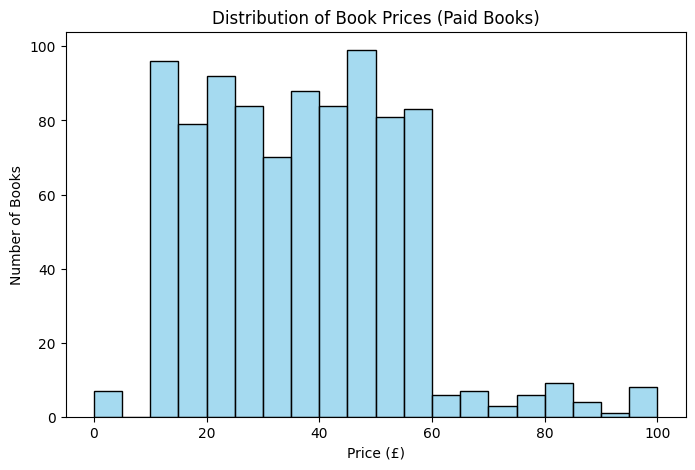

In [17]:
plt.figure(figsize=(8,5))
sns.histplot(df['price'], color='skyblue', bins=20)
plt.title('Distribution of Book Prices (Paid Books)')
plt.xlabel('Price (£)')
plt.ylabel('Number of Books')
plt.show()

In [18]:
print("PRICE ANALYSIS")
print(f"Mean price: £{df['price'].mean():.2f}")
print(f"Median price: £{df['price'].median():.2f}")
print(f"Minimum price: £{df['price'].min():.2f}")
print(f"Maximum price: £{df['price'].max():.2f}")
print(f"Standard deviation: £{df['price'].std():.2f}")

PRICE ANALYSIS
Mean price: £36.72
Median price: £36.74
Minimum price: £0.00
Maximum price: £100.00
Standard deviation: £17.58


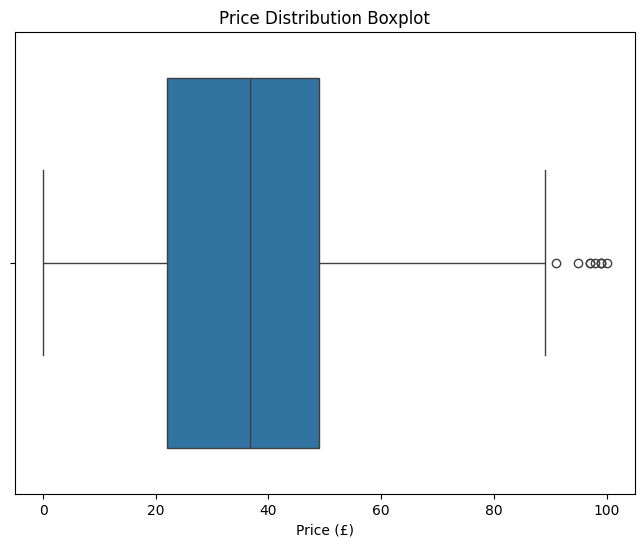

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['price'])
plt.title('Price Distribution Boxplot')
plt.xlabel('Price (£)')
plt.show()

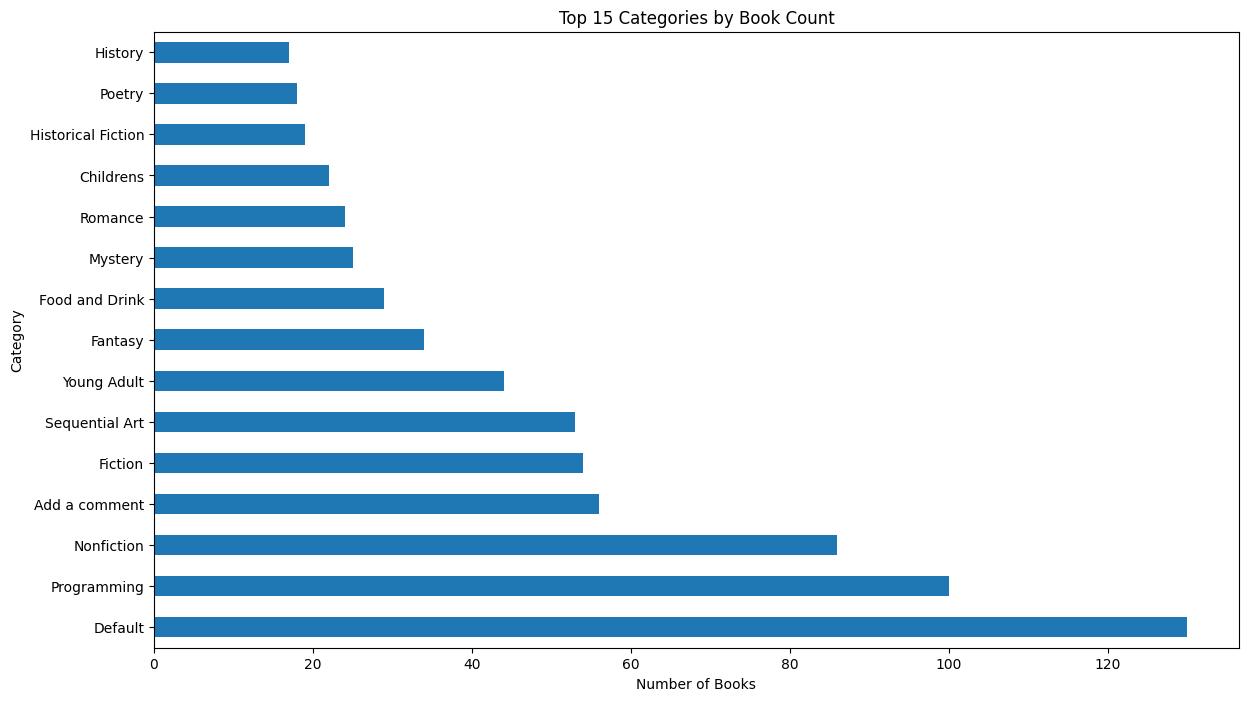

In [20]:
plt.figure(figsize=(14, 8))
df['category'].value_counts().head(15).plot(kind='barh')
plt.title('Top 15 Categories by Book Count')
plt.xlabel('Number of Books')
plt.ylabel('Category')
plt.show()

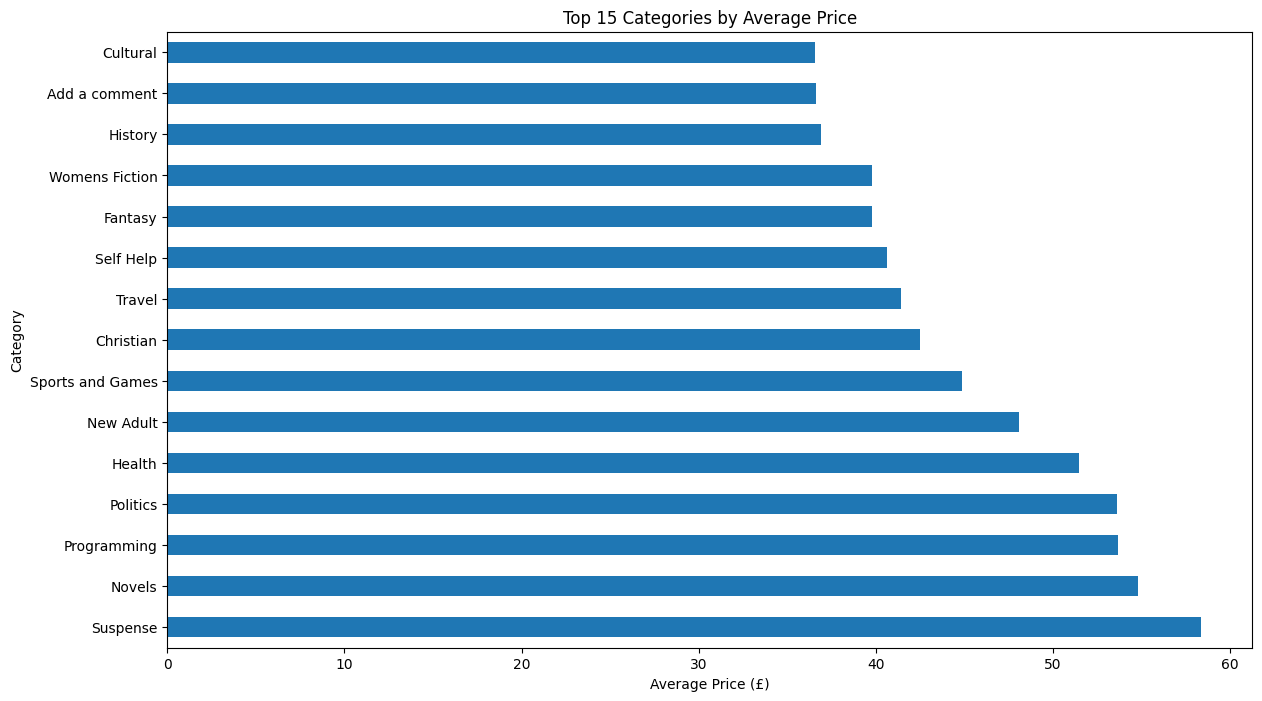

In [21]:
plt.figure(figsize=(14, 8))
df.groupby('category')['price'].mean().sort_values(ascending=False).head(15).plot(kind='barh')
plt.title('Top 15 Categories by Average Price')
plt.xlabel('Average Price (£)')
plt.ylabel('Category')
plt.show()

SOURCE ANALYSIS
Books by source:
 source
Books to Scrape     800
OpenLibrary         100
Google Books API      7
Name: count, dtype: int64


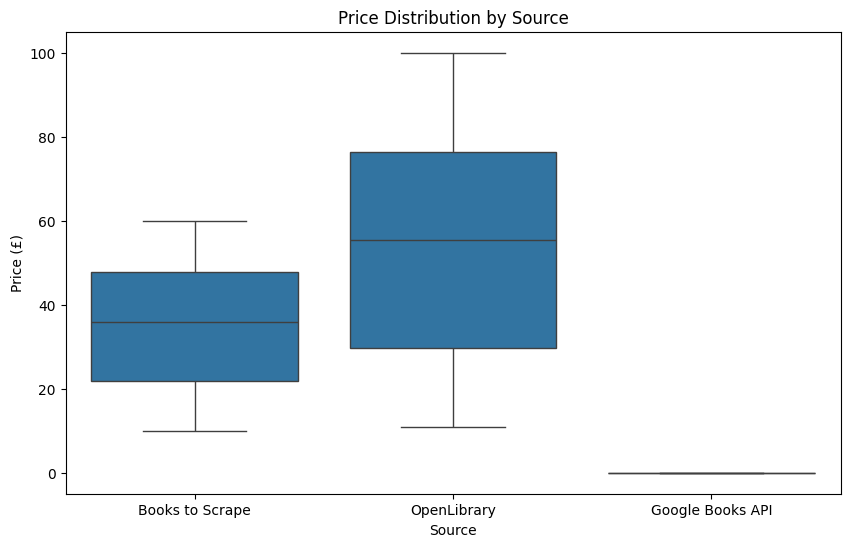

In [22]:
print("SOURCE ANALYSIS")
print("Books by source:\n", df['source'].value_counts())

# Price distribution by source
plt.figure(figsize=(10, 6))
sns.boxplot(x='source', y=df['price'], data=df)
plt.title('Price Distribution by Source')
plt.xlabel('Source')
plt.ylabel('Price (£)')
plt.show()

## 5. Database Connection

In [28]:
from sqlalchemy import create_engine
import urllib

# إعداد الاتصال
params = urllib.parse.quote_plus(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=MOHAMEDHOSSAM\SQLEXPRESS;"
    "DATABASE=BooksDB;"
    "Trusted_Connection=yes;"
)

# إنشاء محرك SQLAlchemy
engine = create_engine(f"mssql+pyodbc:///?odbc_connect={params}")

# حفظ البيانات في جدول اسمه books
df.to_sql('books', con=engine, if_exists='append', index=False)


<>:7: SyntaxWarning: invalid escape sequence '\S'
<>:7: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Al Haitham\AppData\Local\Temp\ipykernel_11240\642072121.py:7: SyntaxWarning: invalid escape sequence '\S'
  "SERVER=MOHAMEDHOSSAM\SQLEXPRESS;"


ProgrammingError: (pyodbc.ProgrammingError) ('42S22', "[42S22] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Invalid column name 'availability_num'. (207) (SQLExecDirectW); [42S22] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Invalid column name 'availability_num'. (207); [42S22] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Statement(s) could not be prepared. (8180)")
[SQL: INSERT INTO books (title, price, rating, availability, category, source, rating_num, availability_num) VALUES (?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?,  ... 6570 characters truncated ... , ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?), (?, ?, ?, ?, ?, ?, ?, ?)]
[parameters: ('A Light in the Attic', 51.77, 'Three', 'In stock', 'Poetry', 'Books to Scrape', 3, 1, 'Tipping the Velvet', 53.74, 'One', 'In stock', 'Historical Fiction', 'Books to Scrape', 1, 1, 'Soumission', 50.1, 'One', 'In stock', 'Fiction', 'Books to Scrape', 1, 1, 'Sharp Objects', 47.82, 'Four', 'In stock', 'Mystery', 'Books to Scrape', 4, 1, 'Sapiens: A Brief History of Humankind', 54.23, 'Five', 'In stock', 'History', 'Books to Scrape', 5, 1, 'The Requiem Red', 22.65, 'One', 'In stock', 'Young Adult', 'Books to Scrape', 1, 1, 'The Dirty Little Secrets of Getting Your Dream Job', 33.34 ... 1996 parameters truncated ... 1, 1, 'The 14th Colony (Cotton Malone #11)', 39.24, 'One', 'In stock', 'Thriller', 'Books to Scrape', 1, 1, 'That Darkness (Gardiner and Renner #1)', 13.92, 'One', 'In stock', 'Mystery', 'Books to Scrape', 1, 1, 'Tastes Like Fear (DI Marnie Rome #3)', 10.69, 'One', 'In stock', 'Mystery', 'Books to Scrape', 1, 1, 'Take Me with You', 45.21, 'Three', 'In stock', 'Fiction', 'Books to Scrape', 3, 1, 'Swell: A Year of Waves', 45.58, 'One', 'In stock', 'Nonfiction', 'Books to Scrape', 1, 1, 'Superman Vol. 1: Before Truth (Superman by Gene Luen Yang #1)', 11.89, 'Five', 'In stock', 'Sequential Art', 'Books to Scrape', 5, 1)]
(Background on this error at: https://sqlalche.me/e/20/f405)